<a href="https://colab.research.google.com/github/kdemertzis/ML_BigData_CyberSecurity-test/blob/master/MetaLearning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install ipython-autotime
 
%load_ext autotime

time: 412 µs (started: 2021-11-20 08:00:59 +00:00)


In [2]:
#!apt-get update && sudo apt-get upgrade

time: 572 µs (started: 2021-11-20 08:00:59 +00:00)


In [3]:
#teiemt.gr
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 6.69 ms (started: 2021-11-20 08:00:59 +00:00)


In [4]:
#!pip install pycaret-nightly[full]
#!pip install modin[ray]

time: 980 µs (started: 2021-11-20 08:00:59 +00:00)


In [5]:
# uninstall lightgbm CPU
#!pip uninstall lightgbm -y
# install lightgbm GPU
#!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

time: 774 µs (started: 2021-11-20 08:00:59 +00:00)


In [6]:
#!pip install pyyaml==5.4.1

time: 4.23 s (started: 2021-11-20 08:00:59 +00:00)


In [7]:
import os, sys, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
import warnings
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import time
import pycaret
import six
import sys
import modin.pandas as pd
from pycaret.classification import *
from psutil import virtual_memory
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, Binarizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import itertools

time: 7.67 s (started: 2021-11-20 08:01:04 +00:00)


In [8]:
#Get total physical memory in Python
mem = virtual_memory()
mem.total  # total physical memory available

13622194176

time: 4.28 ms (started: 2021-11-20 08:01:11 +00:00)


In [9]:
# ----------------------------------------------------------------------
# Performance Measures -------------------------------------------------------------------
# ----------------------------------------------------------------------

time: 1.49 ms (started: 2021-11-20 08:01:11 +00:00)


In [10]:
def CS_performance_measures(y_true, y_pred, labels=None, normal_class=0):
    ''' Cybersecurity / anomaly detection custom performance measures.

    These specific performance measures are designed to assess precisely
    the performance in the case of a multiclass classification task in
    which one class is "special". For cybersecurity for example the 'normal'
    activity is common and a special class in comparison to different
    type of attacks. This class is here indexed as the normal_class variable.

    What happens here is that performance measures are computed at two nested
    levels:
    1) All attacks are merged together and measures are computed
    (i.e. 0 vs. [1,2,3,4] as 1)
    2) Measured are computed on attacks only (i.e. 1 vs. 2 vs. 3 vs. 4)

    Relies on sklearn.metrics.

    labels is a list of labels ids. If labels and their original names are saved in
    a dictionnary with the class names as keys and the ids as index
    (e.g. labels = {'DoS': 0, 'Probe': 1, 'R2L': 2, 'U2R': 3, 'normal': 4}),
    then labels = list(labels.values()).

    normal_class is the index of the class considered as normal (vs. e.g. attack or
    failure depending on the use case)

    Note that in binary classification, recall of the positive class is also
    known as sensitivity; recall of the negative class is specificity.
    '''

    # Make the new (binary classif) vectors corresponding to attack vs normal
    attack_true = np.full(len(y_true), np.nan)
    attack_true[y_true == normal_class] = 0
    attack_true[y_true != normal_class] = 1
    attack_pred = np.full(len(y_pred), np.nan)
    attack_pred[y_pred == normal_class] = 0
    attack_pred[y_pred != normal_class] = 1
    normal_lines = np.logical_or(y_true==0, y_pred==0)
    attack_lines = ~normal_lines
    results = {"accuracy": accuracy_score(attack_true, attack_pred),
               "f1": f1_score(attack_true, attack_pred, average='weighted'),
               "recall-sensitivity": recall_score(attack_true, attack_pred, pos_label=1),
               "recall-specificity": recall_score(attack_true, attack_pred, pos_label=0),
               "precision": precision_score(attack_true, attack_pred, average='weighted'),
               "accuracy_among_attacks": accuracy_score(y_true[attack_lines], y_pred[attack_lines]),
               "f1_among_attacks": f1_score(y_true[attack_lines], y_pred[attack_lines], average='weighted'),
               "recall_among_attacks": recall_score(y_true[attack_lines], y_pred[attack_lines], average='weighted'),
               "precision_among_attacks": precision_score(y_true[attack_lines], y_pred[attack_lines], average='weighted'),
               "cm": confusion_matrix(y_true, y_pred, labels)}
    return results

time: 14.1 ms (started: 2021-11-20 08:01:11 +00:00)


In [11]:
def plot_confusion_matrix(plt, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return(plt)

time: 3.08 ms (started: 2021-11-20 08:01:11 +00:00)


In [12]:
# Directory where the CSV files are located
data_dir = '/content/drive/My Drive/lite/'

time: 708 µs (started: 2021-11-20 08:01:11 +00:00)


In [13]:
# Read the first csv to grab column names
all_files = glob.glob(data_dir + "/*.csv")
df = pd.read_csv(all_files[0], encoding='utf-8')
column_names = list(df.columns) # for removing missing value weirdly encoded in this dataset
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/', '')
df.drop(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'flow_id'], axis=1, inplace=True, errors='ignore')

time: 4.07 s (started: 2021-11-20 08:01:11 +00:00)


In [14]:
# Create personnalized dtypes to be more efficient
mydtypes = {'protocol': 'category',
             'flow_duration': np.uint32,
             'tot_fwd_pkts': np.uint32,
             'tot_bwd_pkts': np.uint32,
             'totlen_fwd_pkts': np.uint32,
             'totlen_bwd_pkts': np.uint32,
             'fwd_pkt_len_max': np.uint32,
             'fwd_pkt_len_min': np.uint32,
             'fwd_pkt_len_mean': np.float32,
             'fwd_pkt_len_std': np.float32,
             'bwd_pkt_len_max': np.uint32,
             'bwd_pkt_len_min': np.uint32,
             'bwd_pkt_len_mean': np.float32,
             'bwd_pkt_len_std': np.float32,
             'flow_bytss': np.float32,
             'flow_pktss': np.float32,
             'flow_iat_mean': np.float32,
             'flow_iat_std': np.float32,
             'flow_iat_max': np.uint32,
             'flow_iat_min': np.uint32,
             'fwd_iat_tot': np.uint32,
             'fwd_iat_mean': np.float32,
             'fwd_iat_std': np.uint32,
             'fwd_iat_max': np.uint32,
             'fwd_iat_min': np.uint32,
             'bwd_iat_tot': np.uint32,
             'bwd_iat_mean': np.uint32,
             'bwd_iat_std': np.uint32,
             'bwd_iat_max': np.uint32,
             'bwd_iat_min': np.uint32,
             'fwd_psh_flags': np.bool_,
             'bwd_psh_flags': np.bool_,
             'fwd_urg_flags': np.bool_,
             'bwd_urg_flags': np.bool_,
             'fwd_header_len': np.uint32,
             'bwd_header_len': np.uint32,
             'fwd_pktss': np.float32,
             'bwd_pktss': np.float32,
             'pkt_len_min': np.uint32,
             'pkt_len_max': np.uint32,
             'pkt_len_mean': np.float32,
             'pkt_len_std': np.float32,
             'pkt_len_var': np.float32,
             'fin_flag_cnt': np.bool_,
             'syn_flag_cnt': np.bool_,
             'rst_flag_cnt': np.bool_,
             'psh_flag_cnt': np.bool_,
             'ack_flag_cnt': np.bool_,
             'urg_flag_cnt': np.bool_,
             'cwe_flag_count': np.bool_,
             'ece_flag_cnt': np.bool_,
             'downup_ratio': np.uint32,
             'pkt_size_avg': np.float32,
             'fwd_seg_size_avg': np.float32,
             'bwd_seg_size_avg': np.float32,
             'subflow_fwd_pkts': np.uint32,
             'subflow_fwd_byts': np.uint32,
             'subflow_bwd_pkts': np.uint32,
             'subflow_bwd_byts': np.uint32,
             'init_fwd_win_byts': np.int32,
             'init_bwd_win_byts': np.int32,
             'fwd_act_data_pkts': np.uint32,
             'fwd_seg_size_min': np.uint32,
             'active_mean': np.float32,
             'active_std': np.float32,
             'active_max': np.uint32,
             'active_min': np.uint32,
             'idle_mean': np.uint32,
             'idle_std': np.float32,
             'idle_max': np.uint32,
             'idle_min': np.uint32,
             'label': 'category'}

time: 3.3 ms (started: 2021-11-20 08:01:16 +00:00)


In [15]:
# ----------------------------------------------------------------------
# CONCATENATE CSVs -----------------------------------------------------
# ----------------------------------------------------------------------

time: 859 µs (started: 2021-11-20 08:01:16 +00:00)


In [16]:
df = pd.DataFrame()
for f in all_files:
    print(f)
    df_temp = pd.read_csv(f, encoding='utf-8', sep=',', na_values=column_names)
    df_temp.columns = df_temp.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/', '')
    print('Before removing columns ' + str(df_temp.shape))
    # Drop columns that are not always present
    df_temp.drop(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'flow_id', 'fwd_bytsb_avg', 'fwd_pktsb_avg', 'fwd_blk_rate_avg', 'bwd_bytsb_avg',
                  'bwd_pktsb_avg', 'bwd_blk_rate_avg'], axis=1, inplace=True, errors='ignore')
    # from fwd_bytsb_avg to bwd_blk_rate_avg are removed because they are always = 0
    df_temp.drop(['timestamp'], axis=1, inplace=True, errors='ignore')
    print('After removing columns ' + str(df_temp.shape))
    # Drop NAs
    df_temp.dropna(axis=0, inplace=True)
    df_temp = df_temp.astype(mydtypes)
    df = pd.concat([df, df_temp], sort=False)
    print(df.shape)
    # Sometimes there is inf values in flow_bytss and flow_pktss
    # df.flow_bytss.isin([np.inf, -np.inf]).sum()
    # they will be replaced later by the maximum value of the training set

/content/drive/My Drive/lite/Thursday-01-03-2019.csv
Before removing columns (232484, 80)
After removing columns (232484, 72)
(232163, 72)
/content/drive/My Drive/lite/Friday-02-03-2019.csv
Before removing columns (195527, 80)
After removing columns (195527, 72)
(427604, 72)
/content/drive/My Drive/lite/Wednesday-21-02-2019.csv
Before removing columns (131374, 80)
After removing columns (131374, 72)
(558978, 72)
/content/drive/My Drive/lite/Friday-16-02-2019.csv
Before removing columns (182166, 80)
After removing columns (182166, 72)
(740861, 72)
/content/drive/My Drive/lite/Wednesday-28-02-2019.csv
Before removing columns (398300, 80)
After removing columns (398300, 72)
(1139154, 72)
time: 17.3 s (started: 2021-11-20 08:01:16 +00:00)


In [17]:
# ----------------------------------------------------------------------
# DATA CLEANING --------------------------------------------------------
# ----------------------------------------------------------------------

time: 917 µs (started: 2021-11-20 08:01:33 +00:00)


In [18]:
print('Replace inf values with the max of the column for variables flow_bytss and flow_pktss')
whereinf = df.flow_bytss.isin([np.inf, -np.inf])
df.flow_bytss[whereinf] = np.nan
df.flow_bytss[whereinf] = df.flow_bytss.max()

whereinf = df.flow_pktss.isin([np.inf, -np.inf])
df.flow_pktss[whereinf] = np.nan
df.flow_pktss[whereinf] = df.flow_pktss.max()

print('Classes and their frequencies in the dataset:')
print(df['label'].value_counts(normalize=True, sort=False))

print('Classes and their number of occurence in the dataset:')
print(df['label'].value_counts(normalize=False, sort=False))

Replace inf values with the max of the column for variables flow_bytss and flow_pktss
Classes and their frequencies in the dataset:
Benign              0.314123
Infilteration       0.094753
DDOS attack-HOIC    0.229932
FTP-BruteForce      0.225927
SSH-Bruteforce      0.078836
DoS attacks-Hulk    0.056430
Name: label, dtype: float64
Classes and their number of occurence in the dataset:
Benign              357834
Infilteration       107938
DDOS attack-HOIC    261928
FTP-BruteForce      257366
SSH-Bruteforce       89806
DoS attacks-Hulk     64282
Name: label, dtype: int64
time: 195 ms (started: 2021-11-20 08:01:33 +00:00)


In [19]:
# ----------------------------------------------------------------------
# TRAIN/TEST SPLIT -----------------------------------------------------
# ----------------------------------------------------------------------

time: 986 µs (started: 2021-11-20 08:01:33 +00:00)


In [20]:
print('Train/test split of the data')
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1),
                                                    df['label'], test_size=0.20, random_state=42)
print('X_train shape is {}'.format(X_train.shape))
print('X_test shape is {}'.format(X_test.shape))

Train/test split of the data
X_train shape is (911323, 71)
X_test shape is (227831, 71)
time: 1.36 s (started: 2021-11-20 08:01:33 +00:00)


In [21]:
# ----------------------------------------------------------------------
# NORMALIZATION --------------------------------------------------------
# ----------------------------------------------------------------------

time: 1.18 ms (started: 2021-11-20 08:01:34 +00:00)


In [22]:
kinds = np.array([dt.kind for dt in X_train.dtypes])
numeric_features = X_train.columns[(kinds != 'O') & (kinds != 'b')]
categorical_features = X_train.columns[kinds == 'O']
boolean_features = X_train.columns[kinds == 'b']
print('Process {} columns as numeric features using minmaxscaler.'.format(len(numeric_features)))
print('Process {} columns as categorical features using one-hot encoding.'.format(len(categorical_features)))
print('Process {} columns as boolean features using binarizer.'.format(len(boolean_features)))

numeric_transformer = Pipeline(steps=[
   ('mms', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))])
# The boolean transformer is useless here but could be at some point, and allows the
# process to be homegeneous among different types of variables
boolean_transformer = Pipeline(steps=[
    ('binarizer', Binarizer())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('boo', boolean_transformer, boolean_features)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

Process 59 columns as numeric features using minmaxscaler.
Process 0 columns as categorical features using one-hot encoding.
Process 12 columns as boolean features using binarizer.
time: 1.61 s (started: 2021-11-20 08:01:34 +00:00)


In [23]:
# ----------------------------------------------------------------------
# LABEL ENCODING -------------------------------------------------------
# ----------------------------------------------------------------------

time: 439 µs (started: 2021-11-20 08:01:36 +00:00)


In [24]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
Label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

time: 254 ms (started: 2021-11-20 08:01:36 +00:00)


In [25]:
# ----------------------------------------------------------------------
# ML -------------------------------------------------------------------
# ----------------------------------------------------------------------

time: 412 µs (started: 2021-11-20 08:01:36 +00:00)


In [26]:
clf=setup(data=df,target='label', use_gpu=True, silent = True, verbose=False)
sys.modules['sklearn.externals.six'] = six

time: 53.2 s (started: 2021-11-20 08:01:36 +00:00)


In [27]:
# compare some baseline models and select top 2
best = compare_models(exclude = ['gbc', 'lr', 'knn', 'ada', 'svm', 'ridge', 'rf', 'et'], cross_validation=False, n_select = 1) 
%load_ext tensorboard
# tune top 5 base models
#tuned_top5 = [tune_model(i) for i in top5]
# ensemble top 5 tuned models
# = [ensemble_model(i) for i in top5]
# blend top 5 base models 
#blender = blend_models(estimator_list = top5) 
# select best model 
#best = automl(optimize = 'Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9860,0.9929,0.9864,0.9863,0.9861,0.9821,0.9821,11.84
xgboost,Extreme Gradient Boosting,0.9860,0.9992,0.9911,0.9874,0.9863,0.9821,0.9822,36.52
catboost,CatBoost Classifier,0.9858,0.9992,0.9903,0.9870,0.9860,0.9818,0.9820,41.34
lda,Linear Discriminant Analysis,0.9655,0.9944,0.9679,0.9683,0.9660,0.9560,0.9565,14.47
qda,Quadratic Discriminant Analysis,0.9363,0.9950,0.9005,0.9340,0.9292,0.9172,0.9195,5.72
nb,Naive Bayes,0.8434,0.9716,0.7810,0.8654,0.8288,0.8005,0.8058,1.30
dummy,Dummy Classifier,0.3140,0.0000,0.1667,0.0986,0.1500,0.0000,0.0000,0.05


time: 2min 55s (started: 2021-11-20 08:02:30 +00:00)


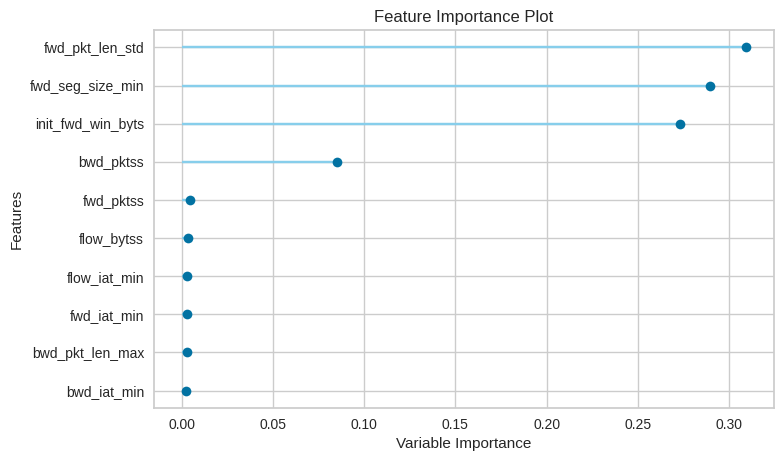

time: 596 ms (started: 2021-11-20 08:05:26 +00:00)


In [28]:
plot_model(best, plot = 'feature')

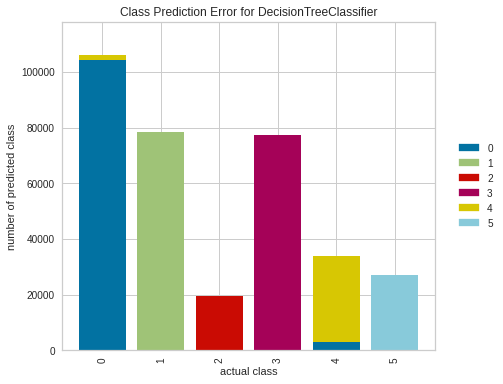

time: 1.24 s (started: 2021-11-20 08:05:26 +00:00)


In [29]:
plot_model(best, plot = 'error')

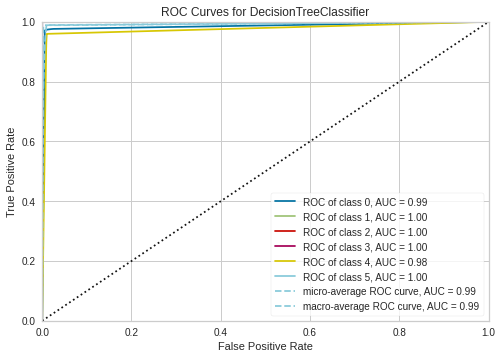

time: 1.44 s (started: 2021-11-20 08:05:27 +00:00)


In [30]:
plot_model(best, plot = 'auc')

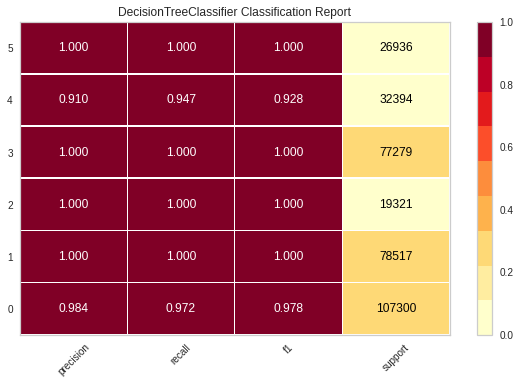

time: 1.24 s (started: 2021-11-20 08:05:29 +00:00)


In [31]:
plot_model(best, plot = 'class_report')

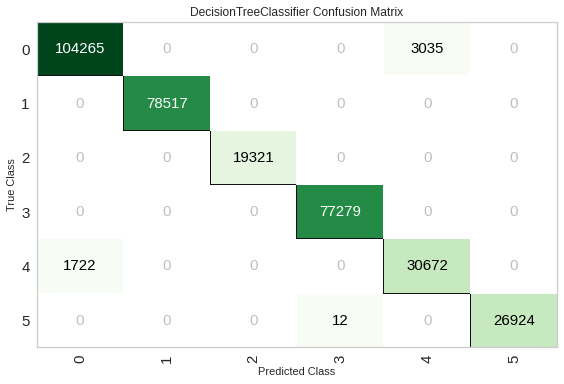

time: 1.38 s (started: 2021-11-20 08:05:30 +00:00)


In [32]:
plot_model(best, plot = 'confusion_matrix')